# Regression with a modular simulation model
* The semi empirical rudder is not part of the regression, but needs to be subtracted from the left hand side.
* Now also with propeller model
* And wind system

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from vessel_manoeuvring_models.models.wind_force import WindForceSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")
model_loader_7m = catalog.load(f"7m.models")


[07/03/23 10:06:09] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=392545;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=456404;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/03/23 10:06:15] INFO     Kedro project phd                                                      ]8;id=344334;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=488326;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=343339;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=341140;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=484885;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=383961;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=872783;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=728916;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=96182;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=366483;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=280131;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=165480;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=620853;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=470075;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=143964;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=410366;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=539701;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=192843;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=54633;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=321280;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model= model_loader["MDL_modular_propeller_rudder"]()

In [5]:
ship_data_7m = catalog.load(f"7m.ship_data")

[07/03/23 10:06:16] INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=983841;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=204187;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
ship_data['A_XV'] = ship_data_7m['A_XV']*ship_data_7m['scale_factor']**2/(ship_data['scale_factor']**2)
ship_data['A_YV'] = ship_data_7m['A_YV']*ship_data_7m['scale_factor']**2/(ship_data['scale_factor']**2)
ship_data['rho_A'] = ship_data_7m['rho_A']
model.ship_parameters.update(ship_data)

In [7]:
#A_XV: 1.120  # Transverse projected area above the waterline including superstructures
#A_YV: 6.037  # Longitudinal projected area above the waterline including superstructures
#rho_A: 1.225 # Mass density of air [kg/m3]

In [8]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
data['twa'] = 0
data['tws'] = 0


In [9]:
result = model.simulate(data)

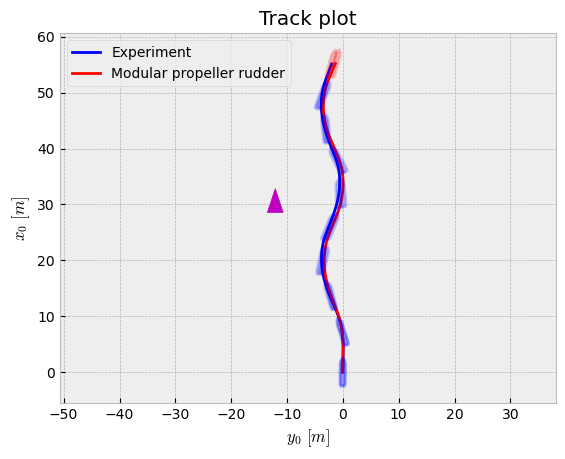

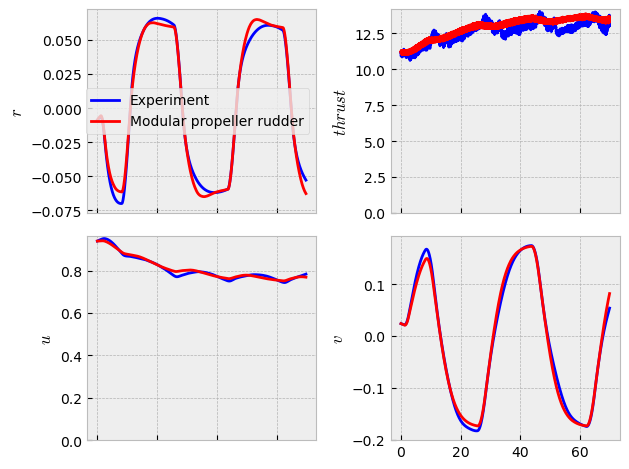

In [10]:
dataframes = {
              'Experiment':data,
              'Modular propeller rudder':result,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [11]:
model.subsystems

{'propellers': <vessel_manoeuvring_models.models.subsystem.EquationSubSystem at 0x7fe36058bb50>,
 'rudders': <vessel_manoeuvring_models.models.semiempirical_rudder.SemiempiricalRudderSystem at 0x7fe36059c160>,
 'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7fe36037f0d0>}

In [12]:
wind_force = WindForceSystem(ship=model, create_jacobians=False)

In [13]:
wind_force.lambdas['awa']

<function vessel_manoeuvring_models.models.wind_force.WindForceSystem.__init__.<locals>.awa_signed_angle(U, cog, psi, twa, tws)>

In [14]:
for eq in wind_force.equations.values():
    display(eq)

Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi)))

Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi)

Eq(X_W, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa))

Eq(Y_W, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa) + A_YV*C_y3*awa**3*aws**2*rho_A)

Eq(N_W, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)

In [15]:
wind_force.equations['aws']

Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

In [16]:
def function_eq(eq):
    return sp.Eq(sp.Function(eq.lhs)(*list(eq.rhs.free_symbols)),eq.rhs)        

In [17]:
function_eq(wind_force.equations['aws'])

Eq(aws(cog, U, tws, twa), sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

In [18]:
wind_force.equations['awa']

Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi)

In [19]:
from vessel_manoeuvring_models.apparent_wind import *
V

(U*cos(cog))*N.i + (U*sin(cog))*N.j

In [20]:
V_S = u * S.i + v * S.j
V_S

u*S.i + v*S.j

In [21]:
V_N = express(V_S,N)
V_N

(u*cos(\Psi) - v*sin(\Psi))*N.i + (u*sin(\Psi) + v*cos(\Psi))*N.j

In [22]:
V_N.dot(N.j)

u*sin(\Psi) + v*cos(\Psi)

In [23]:
V_N.dot(N.i)

u*cos(\Psi) - v*sin(\Psi)

In [24]:
sp.simplify(sp.atan(V_N.dot(N.j) / (V_N.dot(N.i))).diff(u))

-v/(u**2 + v**2)

In [25]:
eq_cog = sp.Eq(cog,sp.atan2(V_N.dot(N.j), (V_N.dot(N.i))))
eq_cog

Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi)))

In [26]:
sp.simplify(eq_cog.rhs.diff(u))

-v/(u**2 + v**2)

## Coefficients

In [27]:
wind_data_HMD = pd.read_csv("HMD_PCTC.wind_data.csv", index_col=0)
wind_data_HMD.rename(columns={column:column.lower().replace(' ','') for column in wind_data_HMD.columns}, inplace=True)
wind_data_HMD.index=360-wind_data_HMD.index
wind_data_HMD.index = np.deg2rad(wind_data_HMD.index)
wind_data_HMD.index = np.mod(wind_data_HMD.index + np.pi, 2 * np.pi) - np.pi
wind_data_HMD['awa'] = wind_data_HMD.index
wind_data_HMD.index.name = "awa [rad]"
wind_data_HMD.sort_index(inplace=True)

In [69]:
from vessel_manoeuvring_models.models.wind_force import eq_C_x, eq_C_y, eq_C_n, C_x, C_y, C_n

In [70]:
eq_to_matrix_C_x = DiffEqToMatrix(eq_C_x, label=C_x, base_features=[awa])
eq_to_matrix_C_y = DiffEqToMatrix(eq_C_y, label=C_y, base_features=[awa])
eq_to_matrix_C_n = DiffEqToMatrix(eq_C_n, label=C_n, base_features=[awa])

In [71]:
eq_C_x

Eq(C_x, C_x0 + C_x1*Abs(awa) + C_x2*awa**2 + C_x3*awa**2*Abs(awa) + C_x4*awa**4 + C_x5*awa**4*Abs(awa))

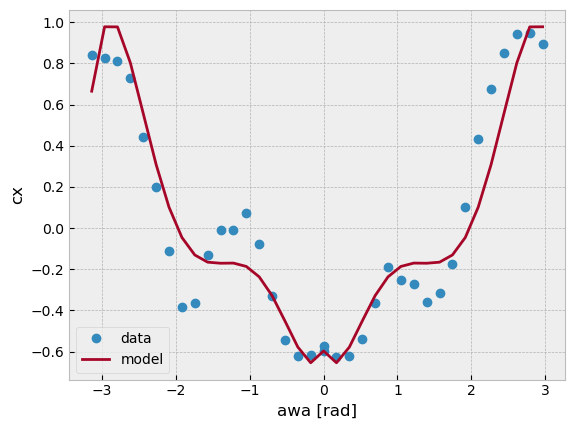

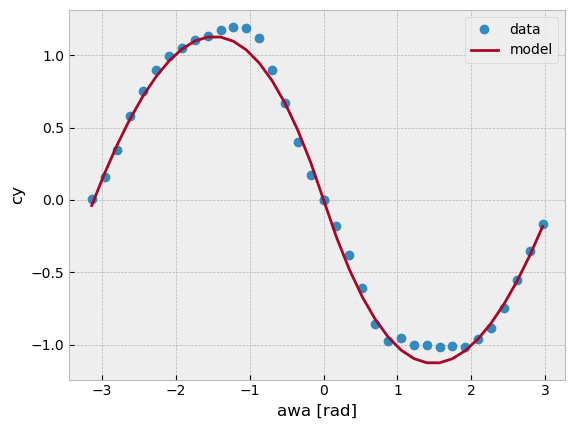

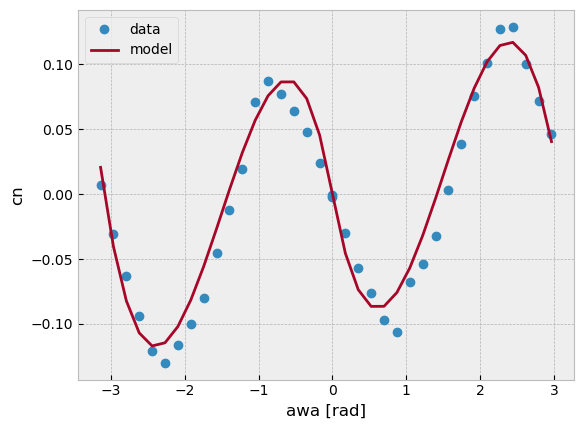

In [73]:
params_wind = {}
for key,eq_to_matrix in zip(['cx','cy','cn'], [eq_to_matrix_C_x, eq_to_matrix_C_y, eq_to_matrix_C_n]):

    X,y = eq_to_matrix.calculate_features_and_label(data=wind_data_HMD, y=wind_data_HMD[key], simplify_names=False)
    ols = sm.OLS(y,X, hasconst=False)
    ols_fit = ols.fit()
    params_wind.update(ols_fit.params)
    
    fig,ax=plt.subplots()
    y.plot(ax=ax,style='o', label='data')
    y_pred = ols_fit.predict(X)
    y_pred.plot(ax=ax, label='model')
    ax.set_ylabel(key)
    ax.legend()
    
params_wind = {key:value/2 for key,value in params_wind.items()}  # Note

## Rebuild ship model

In [74]:
function_eq(wind_force.equations['X_W']).lhs

X_W(C_x2, C_x1, awa, C_x3, C_x4, aws, A_XV, C_x0, rho_A, C_x5)

In [75]:
X_eq = sp.Eq(model.X_eq.lhs, model.X_eq.rhs + function_eq(wind_force.equations['X_W']).lhs)
Y_eq = sp.Eq(model.Y_eq.lhs, model.Y_eq.rhs + function_eq(wind_force.equations['Y_W']).lhs)
N_eq = sp.Eq(model.N_eq.lhs, model.N_eq.rhs + function_eq(wind_force.equations['N_W']).lhs)

In [76]:
parameters = model.parameters.copy()
parameters.update(params_wind)
ship_parameters = model.ship_parameters.copy()
ship_parameters.update(ship_data)

In [77]:
model_wind = model.copy()
model_wind.__init__(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                    parameters=parameters, 
                    ship_parameters=ship_parameters, 
                    control_keys=['delta','rev','twa','tws'], # NOTE! 
                    do_create_jacobian=False)
model_wind.subsystems

{'propellers': <vessel_manoeuvring_models.models.subsystem.EquationSubSystem at 0x7fe356687100>,
 'rudders': <vessel_manoeuvring_models.models.semiempirical_rudder.SemiempiricalRudderSystem at 0x7fe36080fd60>,
 'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7fe356686f20>}

In [78]:
assert model_wind.subsystems['propellers'].ship == model_wind
assert model_wind.subsystems['propellers'].ship != model


In [79]:
model_wind.subsystems['wind_force'] = wind_force.copy_and_refer_other_ship(ship=model_wind)

## Save model

In [80]:
model_loader["MDL_modular_propeller_rudder_wind"] = model_wind
catalog.save(f"{ship}.models",model_loader)

[07/03/23 10:14:03] INFO     Saving data to 'wPCC.models' (PartitionedDataSet)...               ]8;id=427239;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=376252;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [81]:
result_wind = model_wind.simulate(data)

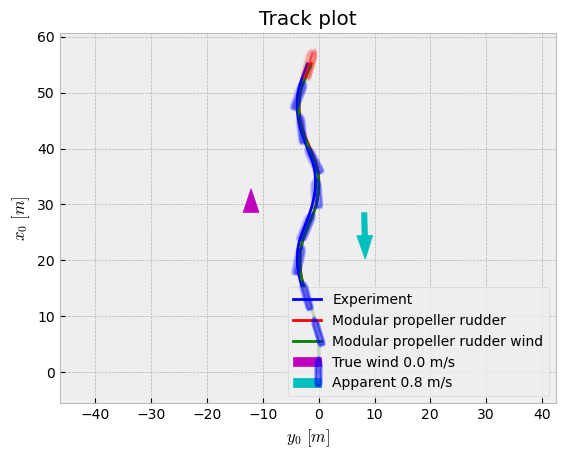

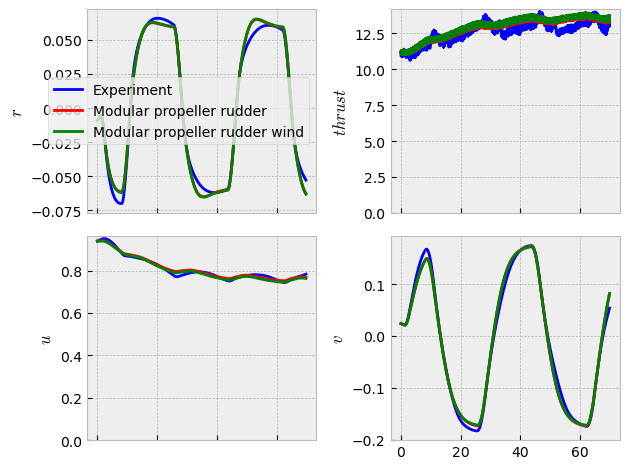

In [82]:
dataframes = {
              'Experiment':data,
              'Modular propeller rudder':result,
              'Modular propeller rudder wind':result_wind,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [83]:
result_wind.head()

,u,v,r,x0,y0,psi,u1d,v1d,r1d,thrust,X_P,V_x,C_L,X_R,Y_R,N_R,X_H,Y_H,N_H,cog,aws,awa,X_W,Y_W,N_W,X_D,Y_D,N_D,beta,U
0.00,0.939222,0.023695,-0.008880,-0.002863,-0.037007,0.007873,0.000649,-0.002308,0.003696,11.271166,9.952440,1.144697,-0.037457,-0.056504,-1.013584,2.455102,-9.326026,-4.149080,1.830808,0.033096,0.939521,0.025223,-0.198365,-0.068477,-0.067322,0.371545,-5.231141,4.218588,-0.025223,0.939521
0.01,0.939229,0.023672,-0.008843,0.006527,-0.036697,0.007784,0.000685,-0.002320,0.003677,11.288304,9.967573,1.145247,-0.037359,-0.056506,-1.011892,2.451004,-9.325842,-4.146825,1.811577,0.032983,0.939527,0.025198,-0.198362,-0.068411,-0.067258,0.386862,-5.227129,4.195323,-0.025198,0.939527
0.02,0.939236,0.023649,-0.008806,0.015917,-0.036388,0.007696,0.000648,-0.002329,0.003654,11.269170,9.950677,1.144640,-0.037286,-0.056416,-1.008840,2.443611,-9.325672,-4.144542,1.792482,0.032870,0.939534,0.025173,-0.198359,-0.068345,-0.067194,0.370230,-5.221727,4.168898,-0.025173,0.939534
0.03,0.939242,0.023625,-0.008770,0.025308,-0.036080,0.007608,0.000469,-0.002335,0.003628,11.180890,9.872726,1.141822,-0.037285,-0.056161,-1.003860,2.431550,-9.325482,-4.142224,1.773542,0.032757,0.939539,0.025148,-0.198356,-0.068279,-0.067130,0.292727,-5.214364,4.137961,-0.025148,0.939539
0.04,0.939247,0.023602,-0.008734,0.034698,-0.035772,0.007521,0.000516,-0.002346,0.003609,11.203162,9.892392,1.142537,-0.037170,-0.056170,-1.001998,2.427039,-9.325277,-4.139874,1.754753,0.032644,0.939544,0.025123,-0.198352,-0.068212,-0.067066,0.312594,-5.210084,4.114726,-0.025123,0.939544


<Axes: >

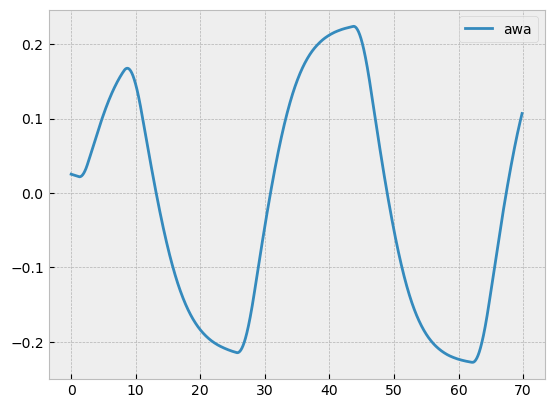

In [84]:
result_wind.plot(y='awa')

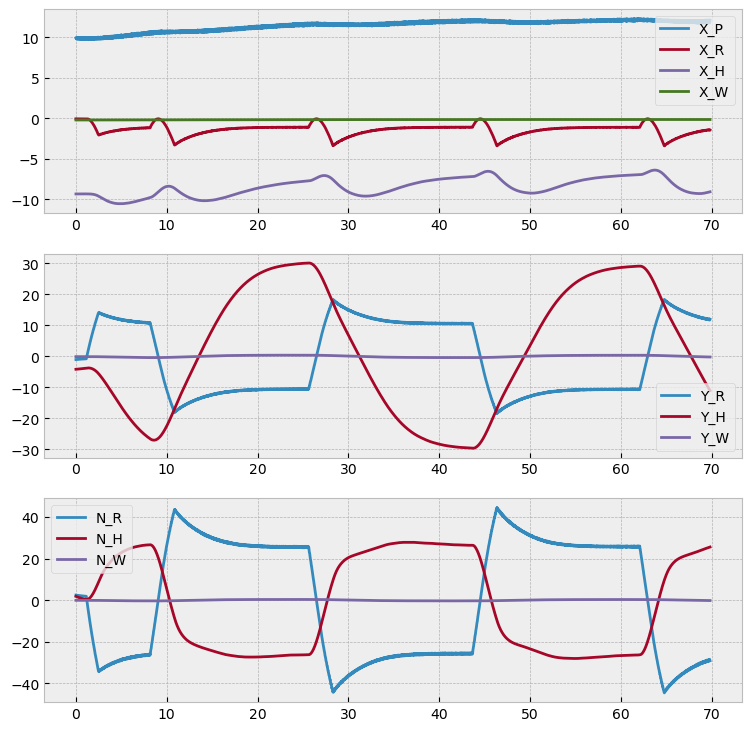

In [85]:
fig,axes=plt.subplots(nrows=3)
fig.set_size_inches(9,9)
for ax,key in zip(axes,['X','Y','N']):
    mask = result_wind.columns.str.contains(key)
    columns = list(result_wind.columns[mask])
    columns.remove(f'{key}_D')
    result_wind.plot(y=columns,ax=ax)

In [86]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2,
 'A_XV': 0.5938354227542653,
 'A_YV': 3.2008789706852667,
 'rho_A': 1.225}

In [87]:
result_wind['C_x'] = result_wind['X_W'] / (result_wind['aws']**2*ship_data['A_XV']*ship_data['rho_A'])
result_wind['C_y'] = result_wind['Y_W'] / (result_wind['aws']**2*ship_data['A_YV']*ship_data['rho_A'])
result_wind['C_n'] = result_wind['N_W'] / (result_wind['aws']**2*ship_data['A_YV']*ship_data['L']*ship_data['rho_A'])

<Axes: xlabel='awa'>

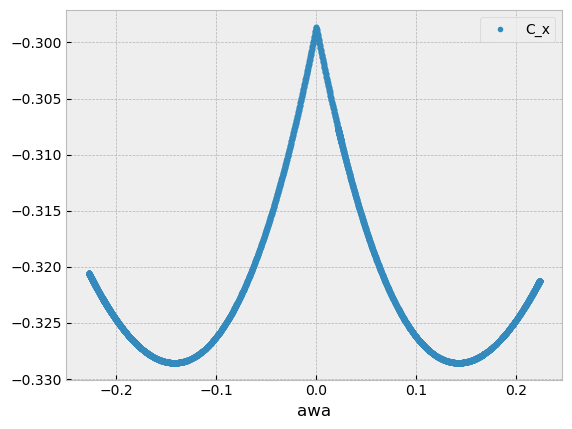

In [88]:
result_wind.plot(x='awa', y='C_x', style='.')

<Axes: xlabel='awa'>

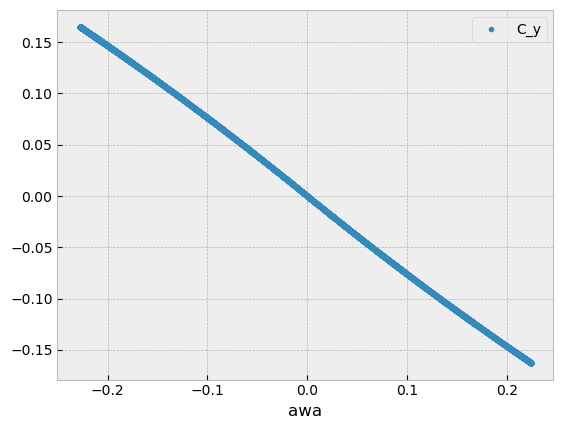

In [89]:
result_wind.plot(x='awa', y='C_y', style='.')

<Axes: xlabel='awa'>

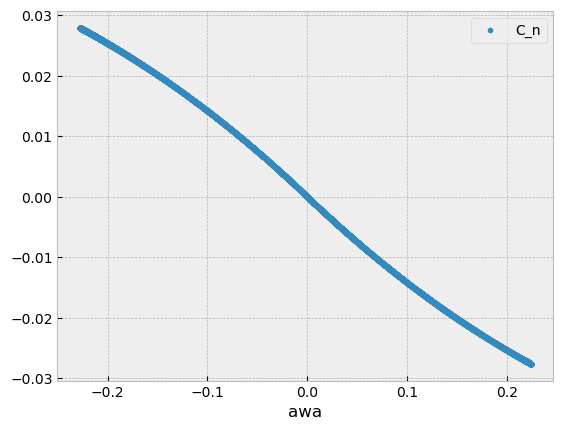

In [90]:
result_wind.plot(x='awa', y='C_n', style='.')

## Also create a 7m model

In [91]:
ship_data_7m

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1025,
 'x_G': -0.3266666666666667,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'CB': 0.41152752056103203,
 'x_r': -3.3168459992407717,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17,
 'A_XV': 1.12,
 'A_YV': 6.037,
 'rho_A': 1.225,
 'n_prop': 2}

In [92]:
ship_parameters_7m = ship_parameters.copy()
ship_parameters_7m.update(ship_data_7m)
scale_7 = ship_data_7m['scale_factor']
scale_5 = ship_data['scale_factor']
scaling = scale_5/scale_7 
ship_parameters_7m['x_p']*=scaling
ship_parameters_7m['x_R']*=scaling
ship_parameters_7m['A_R']*=(scale_5**2)/(scale_7**2)
ship_parameters_7m['b_R']*=scaling
ship_parameters_7m['r_0']=ship_parameters_7m['D']/2
ship_parameters_7m['x']*=scaling


In [93]:
ship_parameters_7m

{'T': 0.284,
 'L': 7.0,
 'CB': 0.41152752056103203,
 'B': 1.3,
 'rho': 1025,
 'x_G': -0.3266666666666667,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'scale_factor': 30,
 'x_r': -3.3168459992407717,
 'TWIN': 1,
 'x_p': -3.326486749598252,
 'D': 0.17,
 'w_p0': 0.151,
 'n_prop': 2,
 'x_R': -3.326486749598252,
 'y_R': 0,
 'z_R': 0,
 'A_R': 0.07777777777777778,
 'b_R': 0.23933333333333334,
 'w_f': 0.151,
 'r_0': 0.085,
 'x': 0.13733333333333336,
 'A_XV': 1.12,
 'A_YV': 6.037,
 'rho_A': 1.225}

<Axes: >

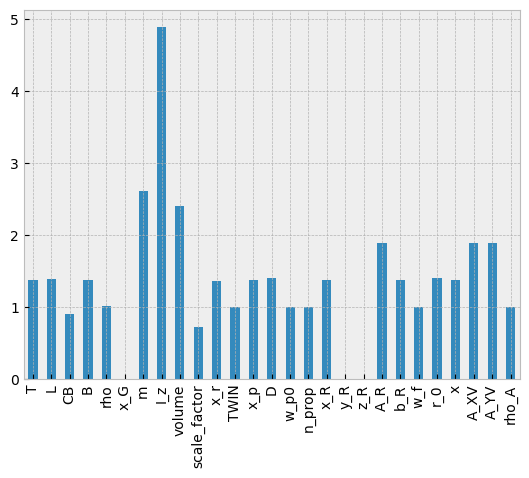

In [94]:
df_ship_parameters = pd.concat((
    pd.Series(ship_parameters_7m, name='7m'),
    pd.Series(ship_parameters, name='5m')),axis=1).transpose()
compare = df_ship_parameters.loc['7m']/df_ship_parameters.loc['5m']
compare.plot.bar()

In [95]:
mask = compare == 1
compare.loc[mask].index

Index(['TWIN', 'w_p0', 'n_prop', 'w_f', 'rho_A'], dtype='object')

In [96]:
model_wind_7m = model_wind.copy()
model_wind_7m.ship_parameters=ship_parameters_7m

## Save model

In [97]:
model_loader_7m["MDL_modular_propeller_rudder_wind"] = model_wind_7m
catalog.save(f"7m.models",model_loader_7m)

[07/03/23 10:14:09] INFO     Saving data to '7m.models' (PartitionedDataSet)...                 ]8;id=21841;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=511532;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [98]:
result_wind_7m = model_wind_7m.simulate(data)

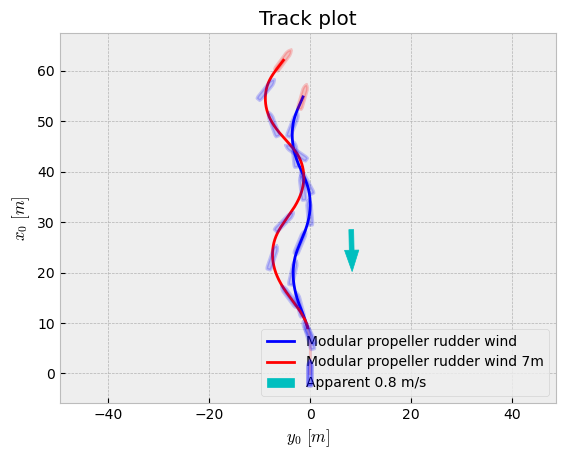

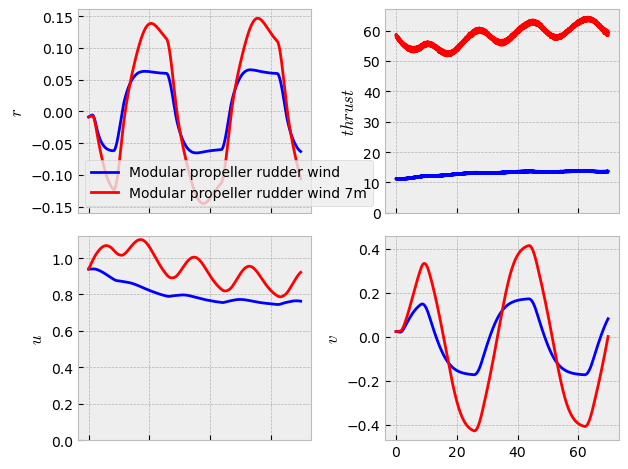

In [99]:
dataframes = {
              'Modular propeller rudder wind':result_wind,
              'Modular propeller rudder wind 7m':result_wind_7m,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [100]:
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters
initial_parameters(ship_data=ship_data)

{'Xudot': 0.00017880704448812042,
 'Yvdot': -0.006109387408263365,
 'Yrdot': -0.00030313777458141895,
 'Nvdot': -0.00012825440172375716,
 'Nrdot': -0.00029867482773178765,
 'Xthrust': 1.0,
 'Ythrustdelta': 0.0,
 'Nthrustdelta': 0.0,
 'Xu': 0.0,
 'Xv': 0.0,
 'Xr': 0.0,
 'Xuu': 0.0,
 'Xvr': 0.0,
 'Xvdelta': 0.0,
 'Xrr': 0.0,
 'Xdeltadelta': 0.0,
 'Yu': 0.0,
 'Yv': -0.009712908347615236,
 'Yr': 0.0024023611364293648,
 'Ydelta': 0.003,
 'Yuv': 0.0,
 'Yur': 0.0,
 'Yvdeltadelta': 0.0,
 'Yrdeltadelta': 0.0,
 'Nu': 0.0,
 'Nv': -0.0031839517092233298,
 'Nr': -0.0017188512353564127,
 'Ndelta': -0.0015,
 'Nuv': 0.0,
 'Nur': 0.0,
 'Nvdeltadelta': 0.0,
 'Nrdeltadelta': 0.0}

In [101]:
ship_data_7m_ = ship_data.copy()
scale_7 = ship_data_7m['scale_factor']
scale_5 = ship_data['scale_factor']
scaling = scale_5/scale_7 


ship_data_7m_['T']*=scaling
ship_data_7m_['L']*=scaling
#ship_data_7m_['CB': 0.45034232324249973,
ship_data_7m_['B']*=scaling
#ship_data_7m_['rho': 1000,
ship_data_7m_['x_G']*=scaling
ship_data_7m_['m']*=scaling**3
ship_data_7m_['I_z']*=scaling**5
ship_data_7m_['volume']*=scaling**3

initial_parameters(ship_data=ship_data_7m_)

{'Xudot': 0.00017880704448812047,
 'Yvdot': -0.006109387408263367,
 'Yrdot': -0.00030313777458141906,
 'Nvdot': -0.00012825440172375735,
 'Nrdot': -0.0002986748277317877,
 'Xthrust': 1.0,
 'Ythrustdelta': 0.0,
 'Nthrustdelta': 0.0,
 'Xu': 0.0,
 'Xv': 0.0,
 'Xr': 0.0,
 'Xuu': 0.0,
 'Xvr': 0.0,
 'Xvdelta': 0.0,
 'Xrr': 0.0,
 'Xdeltadelta': 0.0,
 'Yu': 0.0,
 'Yv': -0.009712908347615238,
 'Yr': 0.002402361136429365,
 'Ydelta': 0.003,
 'Yuv': 0.0,
 'Yur': 0.0,
 'Yvdeltadelta': 0.0,
 'Yrdeltadelta': 0.0,
 'Nu': 0.0,
 'Nv': -0.00318395170922333,
 'Nr': -0.001718851235356413,
 'Ndelta': -0.0015,
 'Nuv': 0.0,
 'Nur': 0.0,
 'Nvdeltadelta': 0.0,
 'Nrdeltadelta': 0.0}

In [102]:
ship_data['B']/ship_data['T']

4.588235294117649

In [103]:
ship_data_7m['B']/ship_data_7m['T']

4.577464788732395